# Pairs Trading

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
import yfinance as yf
import seaborn
import matplotlib.pyplot as plt
#from openbb_terminal.sdk import openbb
import networkx as nx
from scipy import stats
#from concurrent.futures import ProcessPoolExecutor
import plotly.express as px

Getting Equities Data

In [2]:
ftse100_tickers = [
    "III.L", "ABF.L", "ADM.L", "AAL.L", "ANTO.L",
    "AHT.L", "AZN.L", "AUTO.L", "AV.L",
    "AV.L", "BA.L", "BARC.L", "BDEV.L", "BKG.L",
    "BHP.L", "BP.L", "BATS.L", "BLND.L", "BT-A.L",
    "BNZL.L", "BRBY.L", "CCH.L", "CPG.L", "CRH.L",
    "CRDA.L", "DCC.L", "DGE.L", "EVR.L", "EXPN.L",
    "FERG.L", "FLTR.L", "FRES.L", "GSK.L", "GLEN.L",
    "HLMA.L", "HL.L", "HMSO.L", "HSBA.L",
    "IMB.L", "INF.L", "IHG.L", "IAG.L", "ITRK.L",
    "ITV.L", "JD.L", "JMAT.L", "KGF.L", "LAND.L",
    "LGEN.L", "LLOY.L", "MNG.L", "MRO.L",
    "MNDI.L", "NG.L", "NXT.L", "OCDO.L",
    "PSON.L", "PSN.L", "PHNX.L", "POLY.L", "PRU.L",
    "REL.L", "RTO.L", "RIO.L", "RMV.L",
    "RR.L", "SGE.L",
    "SBRY.L", "SDR.L", "SMT.L", "SGRO.L", "SVT.L",
    "SN.L", "SMDS.L", "SMIN.L", "SKG.L", "SPX.L",
    "SSE.L", "STAN.L", "STJ.L", "TW.L",
    "TSCO.L", "TUI.L", "ULVR.L", "UU.L", "VOD.L",
    "WTB.L", "WPP.L"
]


In [3]:
data = yf.download(
    ftse100_tickers, 
    start='2022-10-01', 
    end='2023-09-03'
)['Adj Close']

[*********************100%%**********************]  87 of 87 completed


In [4]:
data.dropna(axis=1, inplace=True)

Checking for co-integration

In [13]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    significant_tickers = set()  # Set to hold tickers with at least one significant p-value
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
                significant_tickers.add(keys[i])
                significant_tickers.add(keys[j])
                    # Convert the set to a list and sort it for consistency
    significant_tickers = sorted(list(significant_tickers))
    
    # Filter the matrices to include only rows/columns for significant tickers
    indices = [keys.get_loc(ticker) for ticker in significant_tickers]
    filtered_pvalue_matrix = pvalue_matrix[np.ix_(indices, indices)]

    return score_matrix, filtered_pvalue_matrix, pairs, significant_tickers

In [14]:
score_matrix, filtered_pvalue_matrix, pairs, significant_tickers = find_cointegrated_pairs(data)

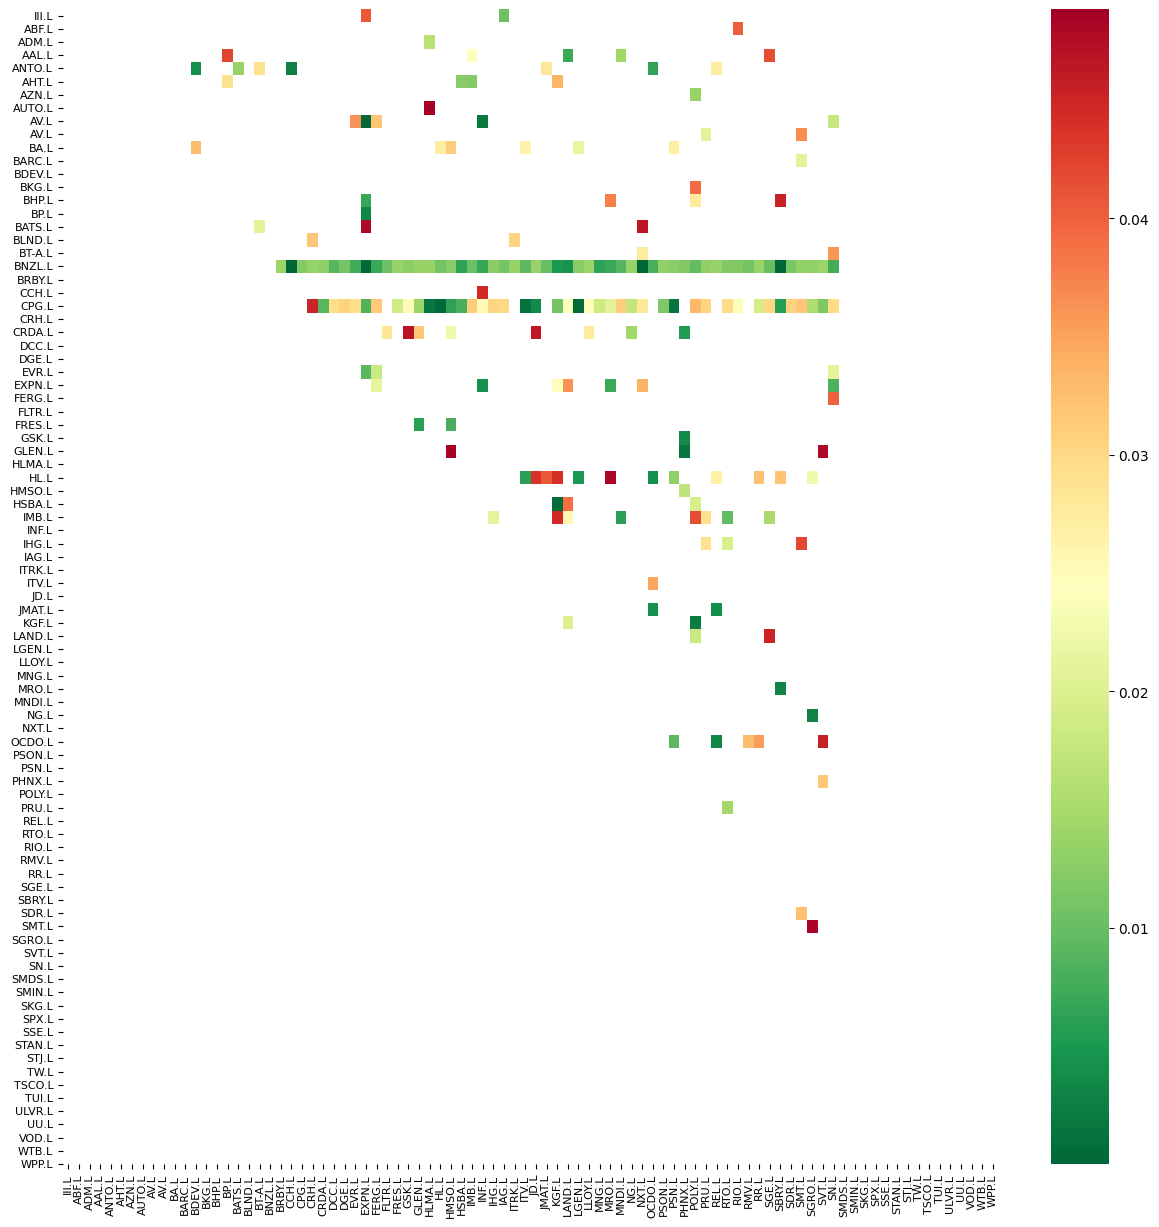

In [15]:
# Set the figure size using Matplotlib
plt.figure(figsize=(15, 15))  # Adjust the dimensions (12, 10) as needed

# Now create the heatmap
ax = seaborn.heatmap(
    filtered_pvalue_matrix, 
    xticklabels=ftse100_tickers, 
    yticklabels=ftse100_tickers, 
    cmap='RdYlGn_r', 
    mask=(filtered_pvalue_matrix >= 0.05)
)

# Optionally, set the size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=8)  # Adjust labelsize as needed

# Show the plot
plt.show()

In [16]:
pvalues_df = pd.DataFrame(filtered_pvalue_matrix, index=significant_tickers, columns=significant_tickers)

# Mask values >= 0.05 by setting them to NaN
masked_pvalues_df = pvalues_df.where(pvalues_df < 0.05)

fig = px.imshow(
    masked_pvalues_df,
    labels=dict(x="Ticker 1", y="Ticker 2", color="P-value"),
    x=significant_tickers,
    y=significant_tickers,
    title="P-values of Cointegrated Pairs",
    color_continuous_scale='RdYlGn_r',  # This is optional, to keep the color scale consistent
    zmin=0,  # This sets the minimum value of the color scale to 0
    zmax=0.05  # This sets the maximum value of the color scale to 0.05
)

fig.update_traces(showscale=True)  # This ensures the color scale is shown

fig.show()

In [17]:
# Extract pairs where p-value is less than 0.05
pairs_to_consider = []
n = filtered_pvalue_matrix.shape[0]  # Assuming filtered_pvalue_matrix is a square matrix

for i in range(n):
    for j in range(i+1, n):
        if filtered_pvalue_matrix[i, j] >= 0.05:
            pairs_to_consider.append((ftse100_tickers[i], ftse100_tickers[j], filtered_pvalue_matrix[i, j]))

# Sort pairs by p-value
pairs_to_consider.sort(key=lambda x: x[2], reverse=True)

# Print the pairs
pairs_to_consider[:10]

[('MNG.L', 'NG.L', 0.9939391039519712),
 ('MNG.L', 'PRU.L', 0.9938942386551786),
 ('MNG.L', 'SVT.L', 0.9934861390126382),
 ('MNG.L', 'SGRO.L', 0.9934810611848588),
 ('MNG.L', 'PHNX.L', 0.9925283585660631),
 ('NXT.L', 'PRU.L', 0.9924498451208483),
 ('MNG.L', 'RR.L', 0.9917154971273681),
 ('NXT.L', 'RTO.L', 0.9896969368798905),
 ('INF.L', 'PRU.L', 0.9880476285093417),
 ('MNG.L', 'RTO.L', 0.988045522711007)]

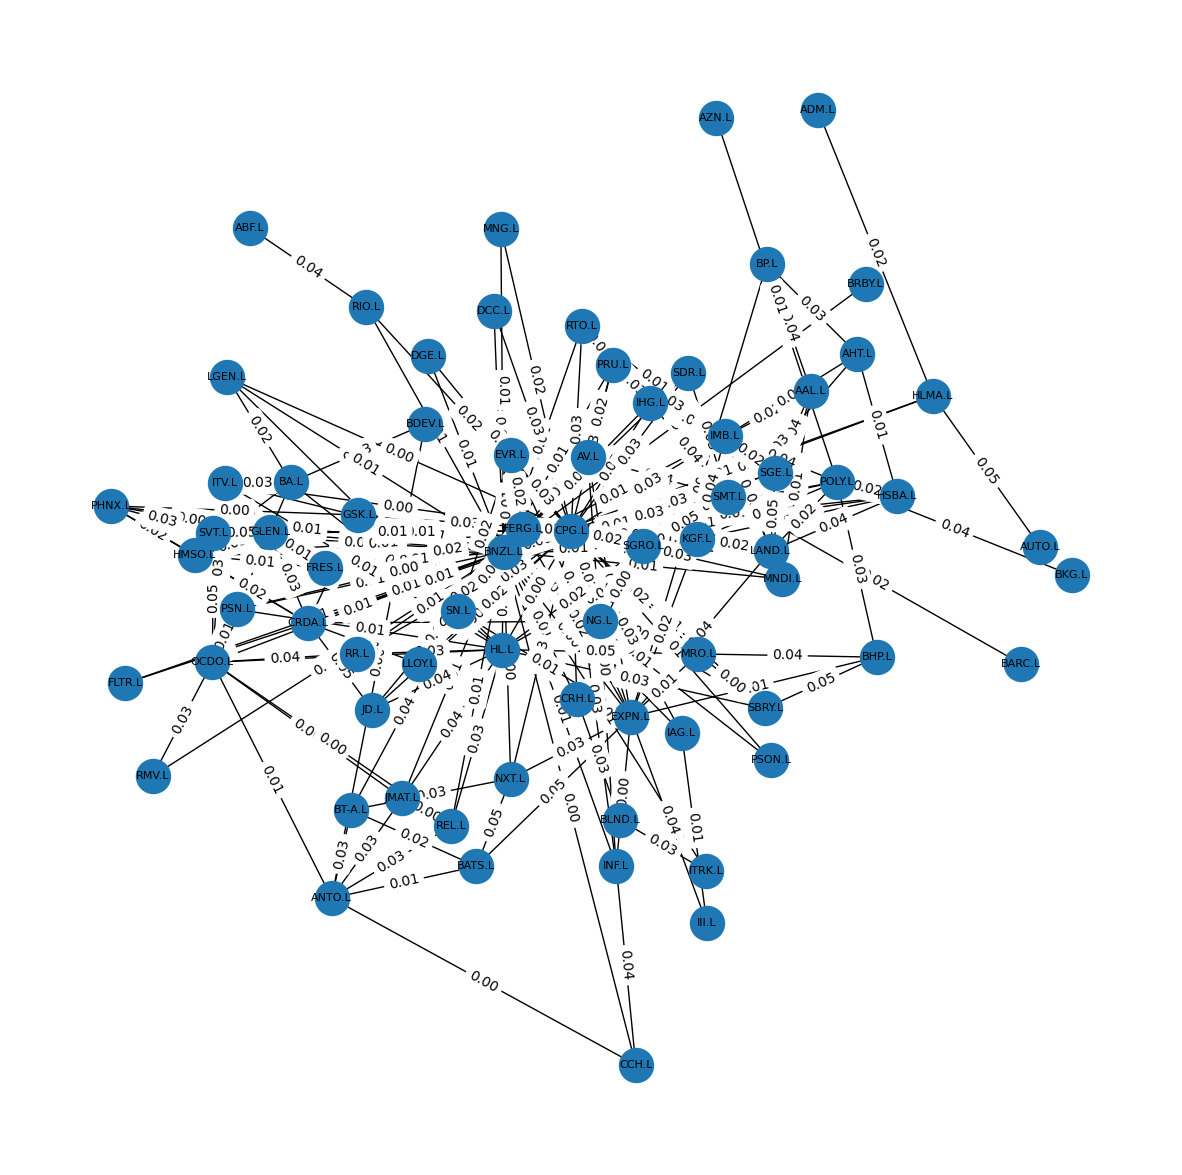

In [36]:
# Create a new graph
plt.figure(facecolor='white', figsize=(15, 15))
G = nx.Graph()

# Assuming filtered_pvalue_matrix is a square matrix
n = filtered_pvalue_matrix.shape[0]

# Add nodes
for ticker in ftse100_tickers[:n]:
    G.add_node(ticker)

# Add edges for significantly cointegrated pairs
for i in range(n):
    for j in range(i+1, n):
        if filtered_pvalue_matrix[i, j] < 0.05:
            G.add_edge(ftse100_tickers[i], ftse100_tickers[j], weight=filtered_pvalue_matrix[i, j])

# Draw the graph with more spread-out nodes
# pos = nx.spring_layout(G, k=0.25)  # increasing k will spread nodes apart
pos = nx.spring_layout(G)  # increasing k will spread nodes apart

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=600)

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

# Draw labels for edges to show weight (p-value in this case)
edge_labels = {(n1, n2): f"{d['weight']:.2f}" for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.axis("off")
plt.show()

In [34]:
import networkx as nx
import plotly.graph_objects as go

# Create a new graph
G = nx.Graph()

# Assuming filtered_pvalue_matrix is a square matrix
n = filtered_pvalue_matrix.shape[0]

# Add nodes
for ticker in significant_tickers:
    G.add_node(ticker)

# Add edges for significantly cointegrated pairs
for i in range(n):
    for j in range(i+1, n):
        if filtered_pvalue_matrix[i, j] < 0.05:  # Note the condition changed to < 0.05 for significant pairs
            G.add_edge(significant_tickers[i], significant_tickers[j], weight=filtered_pvalue_matrix[i, j])

# Create positions for nodes
pos = nx.spring_layout(G)

# Create edges trace
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Create nodes trace
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

hover_text = []
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    hover_text.append(f'{node} connected to: {", ".join(neighbors)}')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=significant_tickers,  # Adding tickers as text labels
    textposition='top center',  # Adjust text position as needed
    hovertext=hover_text,  # Set custom hover text
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2)
)

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Network of Cointegrated Pairs',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()


Top N Pairs:
  Ticker1 Ticker2   p-value
0   MNG.L    NG.L  0.993939
1   MNG.L   PRU.L  0.993894
2   MNG.L   SVT.L  0.993486
3   MNG.L  SGRO.L  0.993481
4   MNG.L  PHNX.L  0.992528
5   NXT.L   PRU.L  0.992450
6   MNG.L    RR.L  0.991715
7   NXT.L   RTO.L  0.989697
8   INF.L   PRU.L  0.988048
9   MNG.L   RTO.L  0.988046


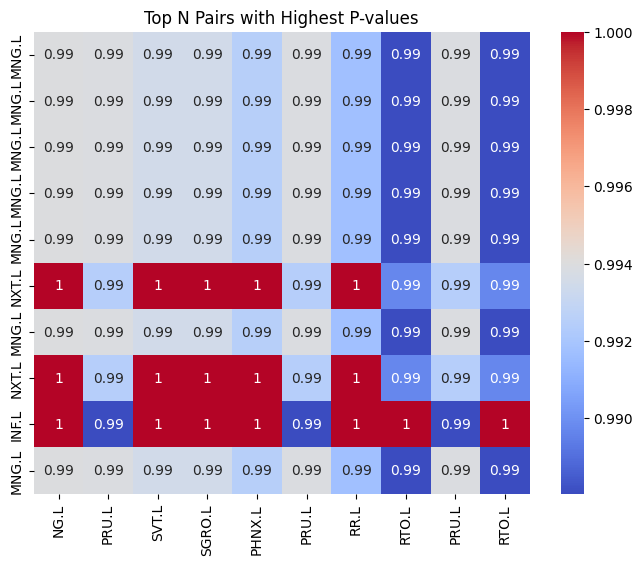

In [19]:
# Take the top N pairs (e.g., N=10)
top_n_pairs = pairs_to_consider[:10]

# Create a DataFrame to hold the top N pairs
df_top_n = pd.DataFrame(top_n_pairs, columns=['Ticker1', 'Ticker2', 'p-value'])

# Display the DataFrame
print("Top N Pairs:")
print(df_top_n)

# Create a smaller heatmap (or table) if you prefer
mini_matrix = pd.DataFrame(index=[x[0] for x in top_n_pairs], columns=[x[1] for x in top_n_pairs])

for ticker1, ticker2, p_value in top_n_pairs:
    mini_matrix.loc[ticker1, ticker2] = p_value

# Convert to float and fill NaNs
mini_matrix = mini_matrix.astype(float).fillna(1)

plt.figure(figsize=(8, 6))
seaborn.heatmap(mini_matrix, annot=True, cmap='coolwarm')
plt.title("Top N Pairs with Highest P-values")
plt.show()

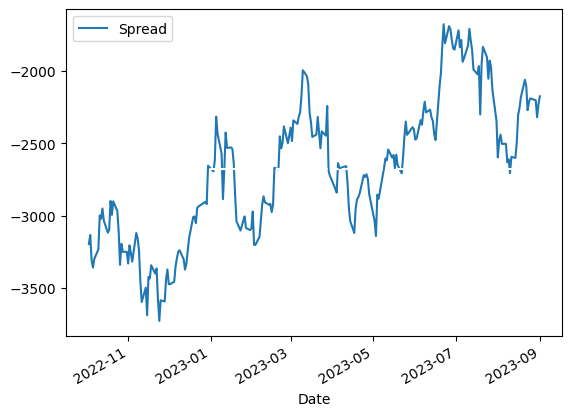

In [20]:
# Extract time series for RMV.L and NXT.L
S1 = data['RMV.L']
S2 = data['NXT.L']

# Add a constant term for intercept in the regression equation
S1_const = sm.add_constant(S1)
# Perform OLS regression
results = sm.OLS(S2, S1_const).fit()
# Extract the slope (beta coefficient)
b = results.params['RMV.L']
# Calculate the spread
spread = S2 - b * S1

# Plot the spread
spread.plot()
plt.axhline(spread.mean(), color='white', linestyle='--')
plt.legend(['Spread'])

In [21]:
S2

Date
2022-10-03    4685.086914
2022-10-04    4873.032715
2022-10-05    4613.395996
2022-10-06    4486.483887
2022-10-07    4317.914062
                 ...     
2023-08-25    6780.000000
2023-08-29    6958.000000
2023-08-30    6936.000000
2023-08-31    6988.000000
2023-09-01    7028.000000
Name: NXT.L, Length: 231, dtype: float64

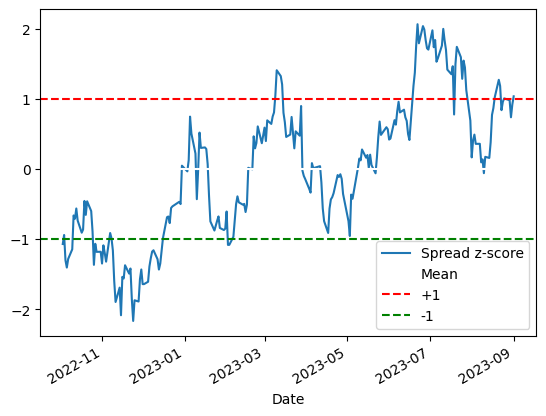

In [22]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='white')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [23]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

<Axes: xlabel='Date'>

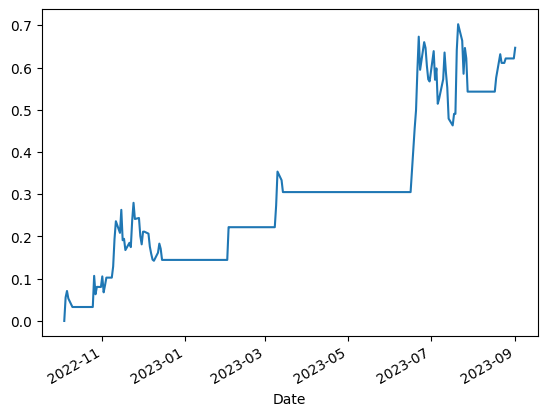

In [24]:
returns = trades.position.pct_change() * trades.side
returns.cumsum().plot()

Backtesting with Backtrader

In [25]:
import backtrader as bt

In [26]:
class PairTradingStrategy(bt.Strategy):
    params = dict(
        period=10
    )

    def __init__(self):
        self.data1 = self.datas[0]
        self.data2 = self.datas[1]
        self.order1 = None
        self.order2 = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def next(self):
        if len(self.data1) < self.params.period:
            return

        S1 = np.array([self.data1.close[-i] for i in range(1, self.params.period + 1)])
        S2 = np.array([self.data2.close[-i] for i in range(1, self.params.period + 1)])

        slope, intercept, r_value, p_value, std_err = stats.linregress(S1, S2)
        self.b = slope

        spread = S2 - self.b * S1
        zscore = (spread - np.mean(spread)) / np.std(spread)

        # self.log(f'Z-Score: {zscore[-1]}')

        if self.order1 or self.order2:
            return  # pending orders exist

        if zscore[-1] > 1:
            self.order1 = self.sell(data=self.data1)
            self.order2 = self.buy(data=self.data2)
        elif zscore[-1] < -1:
            self.order1 = self.buy(data=self.data1)
            self.order2 = self.sell(data=self.data2)

    # def notify_order(self, order):
    #     if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
    #         return

    #     if order.status in [bt.Order.Completed]:
    #         self.log(f'Order completed: {order.executed.price}, {order.executed.value}, {order.executed.size}')

    #     self.order1 = None
    #     self.order2 = None

In [27]:
S1_df = yf.download('RMV.L', start='2022-11-01', end='2023-09-01')
S2_df = yf.download('NXT.L', start='2022-11-01', end='2023-09-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [28]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()

    # Add strategy
    cerebro.addstrategy(PairTradingStrategy)

    # Create data feeds
    data1 = bt.feeds.PandasData(dataname=S1_df)
    data2 = bt.feeds.PandasData(dataname=S2_df)

    # Add data feeds to Cerebro
    cerebro.adddata(data1)
    cerebro.adddata(data2)

    # Set our desired cash start
    cerebro.broker.set_cash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.05)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Print percentage return
    pnl = cerebro.broker.getvalue() - 100000.0
    print(f'Return: {pnl * 100 / 100000.0}%')

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 109091.30
Return: 9.091300231933594%
